In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score, KFold

import matplotlib.pyplot as plt

In [2]:
glogs_final = pd.read_csv('https://raw.githubusercontent.com/tmarchok1/DS440_project/refs/heads/main/glogs_final.csv')
glogs_final

,date,year,week,day_of_week,v_name,h_name,day_night,park_id,temp,precip,capacity,prev_year_wins,made_playoffs,won_division,InstagramFollowers,CityPopulation,attendance
0,2005-04-03,2005,1,Sun,BOS,NYY,1,Old Yankee Stadium,51.7,0.587,56937.0,101,1,1,3900000,19940274,54818.0
1,2005-04-04,2005,1,Mon,OAK,BAL,0,Camden Yards,60.7,0.000,45971.0,78,0,0,746000,2859024,48271.0
2,2005-04-04,2005,1,Mon,CLE,CHW,0,US Cellular Field,56.2,0.000,40615.0,83,0,0,664000,9408576,38141.0
3,2005-04-04,2005,1,Mon,KC,DET,0,Comerica Park,59.0,0.000,41083.0,72,0,0,1000000,4400587,44105.0
4,2005-04-04,2005,1,Mon,MIN,SEA,0,Safeco Field,50.1,0.130,47943.0,63,0,0,927000,4145494,46249.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29030,2016-10-02,2016,24,Sun,MIL,COL,0,Coors Field,78.8,0.000,50144.0,68,0,0,552000,3052498,27762.0
29031,2016-10-02,2016,24,Sun,NYM,PHI,0,Citizens Bank Park,70.5,0.039,43651.0,63,0,0,1300000,6330422,36935.0
29032,2016-10-02,2016,24,Sun,LAD,SF,0,AT&T Park,66.0,0.000,41915.0,84,0,0,1600000,4648486,41445.0
29033,2016-10-02,2016,24,Sun,PIT,STL,0,Busch Stadium III,69.3,0.028,45494.0,100,1,1,1100000,2811927,44615.0


In [3]:
# # Create dummy model using only h_name variable
# homedf = glogs_final.groupby('h_name')['attendance'].mean().sort_values().to_frame()
# dummydf = pd.merge(glogs_final, homedf, on='h_name', how='left')
# dummydf

# # Evaluation metrics for dummy model
# mse = mean_squared_error(dummydf['attendance_x'], dummydf['attendance_y'])
# rmse = mse**(1/2)
# r2 = r2_score(dummydf['attendance_x'], dummydf['attendance_y'])

# print(f'Mean Squared Error (MSE): {mse:.2f}')
# print(f'RMSE: {rmse:.2f}')
# print(f'R-squared Score (R²): {r2:.2f}')

In [3]:
# Data preprocessing

# Drop columns
glogs_final = glogs_final.drop(columns=['date', 'temp'])

# Binary encode 'day_of_week' and 'precip'
glogs_final['day_of_week'] = glogs_final['day_of_week'].map({'Mon':0, 'Tue':0, 'Wed':0, 'Thu':0, 'Fri':1, 'Sat':1, 'Sun':1}).astype('int')
glogs_final['precip'] = glogs_final['precip'].map(lambda x: 1 if x != 0 else 0)
glogs_final

# Apply OneHotEncoder to 'v_name', 'h_name', 'park_id' columns
encoder = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(sparse_output=False), ['week', 'v_name', 'h_name', 'park_id'])],
    remainder='passthrough'  # Keep other columns if there are any
)

df_encoded = encoder.fit_transform(glogs_final)

# Rename columns
feature_names = encoder.get_feature_names_out()
feature_names = [name.replace("remainder__", "") for name in feature_names]

# Convert the result back to a DataFrame (optional)
df_encoded = pd.DataFrame(df_encoded, columns=feature_names)
df_encoded

,cat__week_1,cat__week_2,cat__week_3,cat__week_4,cat__week_5,cat__week_6,cat__week_7,cat__week_8,cat__week_9,cat__week_10,...,day_of_week,day_night,precip,capacity,prev_year_wins,made_playoffs,won_division,InstagramFollowers,CityPopulation,attendance
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,56937.0,101.0,1.0,1.0,3900000.0,19940274.0,54818.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,45971.0,78.0,0.0,0.0,746000.0,2859024.0,48271.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,40615.0,83.0,0.0,0.0,664000.0,9408576.0,38141.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,41083.0,72.0,0.0,0.0,1000000.0,4400587.0,44105.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,47943.0,63.0,0.0,0.0,927000.0,4145494.0,46249.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,50144.0,68.0,0.0,0.0,552000.0,3052498.0,27762.0
29031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,43651.0,63.0,0.0,0.0,1300000.0,6330422.0,36935.0
29032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,41915.0,84.0,0.0,0.0,1600000.0,4648486.0,41445.0
29033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,45494.0,100.0,1.0,1.0,1100000.0,2811927.0,44615.0


In [4]:
df_encoded #model ready dataset
#24 weeks + 60 visitor/home + 36 park ID + day of week + dayNight + precip + capacity + prev yr wins 
#+ made playoffs + won division + IG Followers + City population + attendance = 130 variables 

,cat__week_1,cat__week_2,cat__week_3,cat__week_4,cat__week_5,cat__week_6,cat__week_7,cat__week_8,cat__week_9,cat__week_10,...,day_of_week,day_night,precip,capacity,prev_year_wins,made_playoffs,won_division,InstagramFollowers,CityPopulation,attendance
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,56937.0,101.0,1.0,1.0,3900000.0,19940274.0,54818.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,45971.0,78.0,0.0,0.0,746000.0,2859024.0,48271.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,40615.0,83.0,0.0,0.0,664000.0,9408576.0,38141.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,41083.0,72.0,0.0,0.0,1000000.0,4400587.0,44105.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,47943.0,63.0,0.0,0.0,927000.0,4145494.0,46249.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,50144.0,68.0,0.0,0.0,552000.0,3052498.0,27762.0
29031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,43651.0,63.0,0.0,0.0,1300000.0,6330422.0,36935.0
29032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,41915.0,84.0,0.0,0.0,1600000.0,4648486.0,41445.0
29033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,45494.0,100.0,1.0,1.0,1100000.0,2811927.0,44615.0


In [ ]:
df_encoded

In [5]:
# Build random forest model - 9673 cases from 2005-2008
#modeldata = df_encoded[:9673]

#now building model using cases from 2005-2013
modeldata = df_encoded[df_encoded['year'] <= 2013]


# Define features (X) and target variable (y)
X = modeldata.drop(columns=['attendance'])
y = modeldata['attendance']

# Split data into training / validation / test (80% train, 10% val, 10% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
#X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Initialize the Random Forest regressor
model = RandomForestRegressor(n_estimators=300, random_state=42, max_depth=None, min_samples_leaf=2, min_samples_split=5)
# Train the model
model.fit(X_train, y_train)

# Predict on the val set
y_pred = model.predict(X_test)

# Calculate Mean Squared Error (MSE) and R-squared score (R²)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**(1/2)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R-squared Score (R²): {r2:.2f}')

Mean Squared Error (MSE): 23444676.46
RMSE: 4841.97
R-squared Score (R²): 0.79


In [6]:
########## Error Analysis On 2005-2013 trained model
results = X_test.copy()
results['y_pred'] = y_pred
results['y_test'] = y_test
results['abs_residual'] = abs(results['y_pred'] - results['y_test'])
results

,cat__week_1,cat__week_2,cat__week_3,cat__week_4,cat__week_5,cat__week_6,cat__week_7,cat__week_8,cat__week_9,cat__week_10,...,precip,capacity,prev_year_wins,made_playoffs,won_division,InstagramFollowers,CityPopulation,y_pred,y_test,abs_residual
9352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,37903.0,69.0,0.0,0.0,1000000.0,2253579.0,24617.695551,21107.0,3510.695551
20640,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,41072.0,61.0,0.0,0.0,1900000.0,9408576.0,35018.486423,36590.0,1571.513577
10429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,49586.0,72.0,0.0,0.0,1900000.0,6411149.0,28992.554483,30262.0,1269.445517
21621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,41339.0,98.0,1.0,1.0,711000.0,6436489.0,31519.645126,30636.0,883.645126
1503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,41900.0,67.0,0.0,0.0,670000.0,1574452.0,27090.685552,28971.0,1880.314448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,41339.0,80.0,0.0,0.0,711000.0,6436489.0,25322.548479,30359.0,5036.451521
15573,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,41072.0,75.0,0.0,0.0,1900000.0,9408576.0,39895.498859,41828.0,1932.501141
13424,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,41072.0,83.0,0.0,0.0,1900000.0,9408576.0,40003.057397,40622.0,618.942603
12827,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,42445.0,75.0,0.0,0.0,1400000.0,3298799.0,30148.798694,25956.0,4192.798694


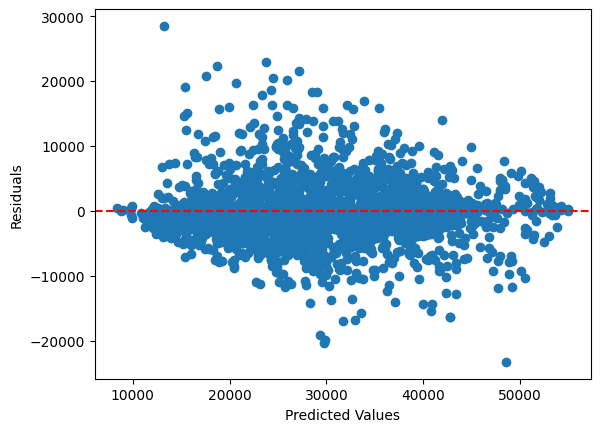

In [8]:

# Calculate residuals
residuals = y_test - y_pred

# Make the plot
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')  # horizontal line at 0
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

#For the residuals, 482 are greater than 0 and 486 are less than 0


In [9]:
results['index'] = range(1, len(results) + 1) #creating index variable to access specific games
results[['index', 'abs_residual']]

#Games with the largest residuals: 
#302 165 448 84 270 38 186 413 379 557 489 565 667 221 521 8 349 729 967 395 661 27 512 577 963 453 262 373 818 29 695 567 88 372
#Games with the smallest residuals:
#69 354 156 432 388 421 401 195 49 647 309 880 402 31 847 556 801 371 436 761 835 357 216 76 269 18 599 873 962 235 501 863 772 189


,index,abs_residual
9352,1,3510.695551
20640,2,1571.513577
10429,3,1269.445517
21621,4,883.645126
1503,5,1880.314448
...,...,...
19163,2174,5036.451521
15573,2175,1932.501141
13424,2176,618.942603
12827,2177,4192.798694


In [10]:

#Converting dummy variables back for easier analysis
one_hot_cols = [col for col in results.columns if col.startswith('cat__h_name_')]
results['h_name'] = results[one_hot_cols].idxmax(axis=1).str.replace('cat__h_name_', '', regex=False)

one_hot_cols_v = [col for col in results.columns if col.startswith('cat__v_name_')]
results['v_name'] = results[one_hot_cols_v].idxmax(axis=1).str.replace('cat__v_name_', '', regex=False)

one_hot_cols_week = [col for col in results.columns if col.startswith('cat__week_')]
results['week_number'] = results[one_hot_cols_week].idxmax(axis=1).str.replace('cat__week_', '', regex=False)


In [11]:
results_sub = results[['h_name','v_name','week_number','prev_year_wins','capacity','y_pred','y_test','abs_residual']]
results_sub

,h_name,v_name,week_number,prev_year_wins,capacity,y_pred,y_test,abs_residual
9352,KC,CLE,21,69.0,37903.0,24617.695551,21107.0,3510.695551
20640,CHC,PIT,13,61.0,41072.0,35018.486423,36590.0,1571.513577
10429,ATL,CHC,8,72.0,49586.0,28992.554483,30262.0,1269.445517
21621,WSH,ATL,22,98.0,41339.0,31519.645126,30636.0,883.645126
1503,MIL,ARI,15,67.0,41900.0,27090.685552,28971.0,1880.314448
...,...,...,...,...,...,...,...,...
19163,WSH,LAD,22,80.0,41339.0,25322.548479,30359.0,5036.451521
15573,CHC,NYY,11,75.0,41072.0,39895.498859,41828.0,1932.501141
13424,CHC,PHI,14,83.0,41072.0,40003.057397,40622.0,618.942603
12827,SD,WSH,8,75.0,42445.0,30148.798694,25956.0,4192.798694


In [12]:
results_sub[results_sub['abs_residual'] > 5000]

,h_name,v_name,week_number,prev_year_wins,capacity,y_pred,y_test,abs_residual
4844,WSH,MIA,1,71.0,45596.0,26865.556236,40389.0,13523.443764
5388,NYM,CHC,6,97.0,57333.0,40854.113072,34033.0,6821.113072
19344,LAD,SF,24,82.0,56000.0,42474.971505,34014.0,8460.971505
16559,TB,BAL,20,96.0,42735.0,17725.076260,11955.0,5770.076260
14813,MIA,COL,3,80.0,47662.0,19190.008718,11442.0,7748.008718
...,...,...,...,...,...,...,...,...
10978,SF,SD,13,72.0,41915.0,36438.320165,41913.0,5474.679835
409,ATL,HOU,5,96.0,49586.0,25683.057702,20553.0,5130.057702
20497,BAL,CLE,12,93.0,45971.0,23897.925482,18082.0,5815.925482
3592,OAK,ARI,12,88.0,47170.0,22310.360224,16756.0,5554.360224


In [ ]:
home_counts = results_sub['h_name'].value_counts()
visitor_counts = results_sub['v_name'].value_counts()
home_counts, visitor_counts 
#Home: Worst on LAA, SD, TOR, CHC, MIN, CIN, OAK
#Away: CHC, MIL, LAD, NYY, SD, CLE, SF

In [ ]:
#Dictionary showing the proportion of overestimates from the model (works with full results, not just largest residuals subset)
count_dict = {}
home_teams = results['h_name'].unique()

for team in home_teams:
    team_games = results[results['h_name'] == team]
    count_dict[team] = ((team_games['y_pred'] > team_games['y_test']).sum()) / np.float64((team_games['y_pred'] > team_games['y_test']).sum() + (team_games['y_pred'] < team_games['y_test']).sum())


count_df = pd.DataFrame(list(count_dict.items()), columns=['Home Team', 'Prop_OverEstimate'])
count_df['Prop_OverEstimate'] = count_df['Prop_OverEstimate'].round(3)
print(count_df)



In [28]:
#avg_byTeam stored the home team, the average residual for games played with this team as the home team, 
#and the variance of the attendance for these games

#Trying to compare model results with variability. Would expect more variability to lead to worse performance


results_byTeam = results.groupby('h_name', as_index=False)['abs_residual'].mean().rename(columns={'abs_residual': 'mean_abs_residual'})


#now, look at the variance of each teams attendance 
var_byTeam = glogs_final.groupby('h_name')['attendance'].std().reset_index().rename(columns={'attendance': 'attendance_stdDeviation'})

results_byTeam['attendance_variance'] = var_byTeam['attendance_stdDeviation']

results_byTeam['res_rank'] = results_byTeam['mean_abs_residual'].rank(method='min')
results_byTeam['var_rank'] = results_byTeam['attendance_variance'].rank(method='min')
results_byTeam['diff'] = results_byTeam['res_rank'] - results_byTeam['var_rank']

results_byTeam 

,h_name,mean_abs_residual,attendance_variance,res_rank,var_rank,diff
0,ARI,3364.962782,7218.213863,13.0,10.0,3.0
1,ATL,4175.089729,9324.498731,21.0,27.0,-6.0
2,BAL,4978.255534,10375.327064,29.0,29.0,0.0
3,BOS,474.489230,1500.967861,1.0,1.0,0.0
4,CHC,1778.682406,3914.739965,5.0,5.0,0.0
5,CHW,3197.974448,7608.561064,11.0,13.0,-2.0
6,CIN,3984.842246,8542.010872,20.0,22.0,-2.0
7,CLE,3833.676344,8106.046417,17.0,19.0,-2.0
8,COL,4368.827967,8065.195004,25.0,18.0,7.0
9,DET,2935.292976,7180.300263,8.0,9.0,-1.0


In [ ]:
#within month (running average), proportion above/below actual
#temporal pattern 

#Residuals over time (color training residuals in one, test in another). dont do absolute value
#Then, could look at by team


#Average residual by team

In [ ]:
#Could add team payroll. With no salary cap, it could capture market size and player success (better players are likely to make more money)

In [15]:
# # Random Forest hyperparameter tuning
# # Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
# # Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}

# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10, 20],
#     'min_samples_leaf': [1, 2, 4]
# }

# grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
# grid_search.fit(X_train, y_train)

# print("Best Parameters:", grid_search.best_params_)

In [16]:
# # Build random forest model - 21776 cases from 2005-2013
# modeldata = df_encoded[:21776]

# # Define features (X) and target variable (y)
# X = modeldata.drop(columns=['attendance'])
# y = modeldata['attendance']

# # Split data into training / test (80% train, 20% test)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# # Initialize the Random Forest regressor
# model = RandomForestRegressor(n_estimators=300, random_state=42, max_depth=None, min_samples_leaf=2, min_samples_split=5)

# # Set up K-Fold Cross-Validation
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# # Perform cross-validation and get the average score
# cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')

# print("Cross-validation R-squared scores:", cv_scores)
# print("Mean CV R-squared:", cv_scores.mean())


# # # Fit the model
# # model.fit(X_train, y_train)

# # # Predict on the val set
# # y_pred = model.predict(X_test)

# # # Calculate Mean Squared Error (MSE) and R-squared score (R²)
# # mse = mean_squared_error(y_test, y_pred)
# # rmse = mse**(1/2)
# # r2 = r2_score(y_test, y_pred)

# # print(f'Mean Squared Error (MSE): {mse:.2f}')
# # print(f'RMSE: {rmse:.2f}')
# # print(f'R-squared Score (R²): {r2:.2f}')